In [31]:
# for data processing
import pandas as pd
import numpy as np
import glob

# for visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import requests

!python -V

Python 3.8.12


In [2]:
# Korean font setting
# 모든 정보가 한국어로 되어 있습니다. 폰트 설정을 하지 않으면 시각화 시 폰트가 깨지기 때문에 설정해주겠습니다.

from matplotlib import font_manager
font_list = font_manager.findSystemFonts(fontpaths=None, fontext='ttf')
plt.rc('font', family='NanumGothic')

In [5]:
import os
os.getcwd()

'/data02/jo/sources/data-analysis/dacon/traffic-accident-casuality-prediction'

# Data Load

In [6]:
train = pd.read_csv('../dataset/traffic-accident-casuality-prediction/train.csv')
test = pd.read_csv('../dataset/traffic-accident-casuality-prediction/test.csv')

countrywide_accidents = pd.read_csv('../dataset/traffic-accident-casuality-prediction/external_open/countrywide_accident.csv')
cctvs = pd.read_csv('../dataset/traffic-accident-casuality-prediction//external_open/대구 CCTV 정보.csv', encoding='cp949')
security_lights = pd.read_csv('../dataset/traffic-accident-casuality-prediction//external_open/대구 보안등 정보.csv', encoding='cp949')
school_zones = pd.read_csv('../dataset/traffic-accident-casuality-prediction/external_open/대구 어린이 보호 구역 정보.csv', encoding='cp949')
parking_lots = pd.read_csv('../dataset/traffic-accident-casuality-prediction/external_open/대구 주차장 정보.csv', encoding='cp949')

/tmp/ipykernel_88962/719511987.py:6: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  security_lights = pd.read_csv('../dataset/traffic-accident-casuality-prediction//external_open/대구 보안등 정보.csv', encoding='cp949')


In [192]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39609 entries, 0 to 39608
Data columns (total 23 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           39609 non-null  object
 1   사고일시         39609 non-null  object
 2   요일           39609 non-null  object
 3   기상상태         39609 non-null  object
 4   시군구          39609 non-null  object
 5   도로형태         39609 non-null  object
 6   노면상태         39609 non-null  object
 7   사고유형         39609 non-null  object
 8   사고유형 - 세부분류  39609 non-null  object
 9   법규위반         39609 non-null  object
 10  가해운전자 차종     39609 non-null  object
 11  가해운전자 성별     39609 non-null  object
 12  가해운전자 연령     39609 non-null  object
 13  가해운전자 상해정도   39609 non-null  object
 14  피해운전자 차종     38618 non-null  object
 15  피해운전자 성별     38618 non-null  object
 16  피해운전자 연령     38618 non-null  object
 17  피해운전자 상해정도   38618 non-null  object
 18  사망자수         39609 non-null  int64 
 19  중상자수         39609 non-nu

In [8]:
# 데이터를 부르기 쉽게 짧고, 직관적으로 컬럼명을 바꿔주겠습니다.

train.columns = ['ID', 'datetime', 'dayWeek', 'weather', 'location',
                 'roadType', 'roadState',
                 'accidentType', 'accidentType_detail',
                 'violation',
                 'modelF', 'genderF', 'ageF', 'injuryF', # drive at Fault의 F
                 'modelV', 'genderV', 'ageV', 'injuryV', # victim의 V
                 'death', 'injuredS', 'injuredL', 'injured', # injuredS: Severly injured, injuredL: Lightly injured
                 'ECLO']

test.columns = ['ID', 'datetime', 'day', 'weather', 'location',
                'roadType', 'roadState',
                'accidentType']

target = "ECLO"

In [9]:
train.sample(10)

,ID,datetime,dayWeek,weather,location,roadType,roadState,accidentType,accidentType_detail,violation,...,injuryF,modelV,genderV,ageV,injuryV,death,injuredS,injuredL,injured,ECLO
10135,ACCIDENT_10135,2019-09-21 20,토요일,비,대구광역시 동구 봉무동,교차로 - 교차로안,젖음/습기,차대차,정면충돌,중앙선침범,...,상해없음,승용,남,31세,경상,0,1,1,0,8
19063,ACCIDENT_19063,2020-05-22 14,금요일,맑음,대구광역시 중구 삼덕동2가,단일로 - 기타,건조,차대차,기타,중앙선침범,...,부상신고,승용,남,38세,상해없음,0,0,0,1,1
38697,ACCIDENT_38697,2021-12-03 13,금요일,맑음,대구광역시 달서구 유천동,단일로 - 기타,건조,차대차,추돌,안전거리미확보,...,상해없음,화물,남,34세,중상,0,1,3,0,14
11200,ACCIDENT_11200,2019-10-14 20,월요일,맑음,대구광역시 수성구 연호동,교차로 - 교차로안,건조,차대차,측면충돌,교차로운행방법위반,...,상해없음,승용,여,40세,경상,0,0,1,0,3
1490,ACCIDENT_01490,2019-02-14 14,목요일,맑음,대구광역시 중구 공평동,단일로 - 기타,건조,차대사람,길가장자리구역통행중,안전운전불이행,...,상해없음,보행자,여,12세,경상,0,0,1,0,3
13172,ACCIDENT_13172,2019-11-29 07,금요일,맑음,대구광역시 달서구 두류동,단일로 - 기타,건조,차대차,측면충돌,안전운전불이행,...,중상,화물,남,48세,상해없음,0,1,0,0,5
14842,ACCIDENT_14842,2020-01-09 19,목요일,맑음,대구광역시 서구 원대동3가,단일로 - 기타,건조,차대차,기타,기타,...,상해없음,자전거,여,51세,경상,0,0,1,0,3
29356,ACCIDENT_29356,2021-03-03 06,수요일,비,대구광역시 수성구 범물동,교차로 - 교차로부근,젖음/습기,차대차,측면충돌,안전운전불이행,...,상해없음,승용,남,48세,경상,0,0,1,0,3
4920,ACCIDENT_04920,2019-05-13 09,월요일,맑음,대구광역시 달성군 화원읍,교차로 - 교차로부근,건조,차대차,기타,교차로운행방법위반,...,중상,화물,남,65세,경상,0,2,1,0,13
32963,ACCIDENT_32963,2021-06-15 14,화요일,비,대구광역시 달서구 본리동,단일로 - 기타,젖음/습기,차대차,기타,안전운전불이행,...,부상신고,승용,남,30세,상해없음,0,0,0,1,1


In [10]:
train.isnull().sum()

ID                       0
datetime                 0
dayWeek                  0
weather                  0
location                 0
roadType                 0
roadState                0
accidentType             0
accidentType_detail      0
violation                0
modelF                   0
genderF                  0
ageF                     0
injuryF                  0
modelV                 991
genderV                991
ageV                   991
injuryV                991
death                    0
injuredS                 0
injuredL                 0
injured                  0
ECLO                     0
dtype: int64

In [11]:
print(set(train.modelV.values))
print(set(train.genderV.values))
print(set(train.ageV.values))
print(set(train.injuryV.values)) # null값을 어떻게 처리해 줘야할지 알아보기 위해 null값을 갖는 컬럼들의 value를 프린트 해보겠습니다.

{nan, '농기계', '화물', '승용', '승합', '원동기', '이륜', '자전거', '개인형이동수단(PM)', '보행자', '특수', '사륜오토바이(ATV)', '건설기계', '기타불명'}
{'여', nan, '남', '기타불명'}
{'61세', nan, '64세', '16세', '41세', '76세', '58세', '34세', '22세', '75세', '55세', '13세', '18세', '86세', '63세', '48세', '29세', '38세', '84세', '74세', '27세', '14세', '37세', '44세', '52세', '59세', '미분류', '77세', '54세', '45세', '35세', '33세', '28세', '12세', '42세', '15세', '49세', '10세', '6세', '73세', '17세', '30세', '24세', '2세', '82세', '11세', '4세', '71세', '39세', '98세 이상', '1세', '91세', '90세', '79세', '9세', '56세', '51세', '72세', '21세', '88세', '46세', '40세', '47세', '70세', '92세', '90세 이상', '7세', '20세', '68세', '31세', '69세', '80세', '65세', '3세', '66세', '85세', '26세', '53세', '8세', '23세', '19세', '50세', '93세', '62세', '94세', '87세', '67세', '32세', '78세', '5세', '83세', '57세', '60세', '25세', '36세', '89세', '81세', '43세'}
{'경상', nan, '중상', '상해없음', '사망', '부상신고', '기타불명'}


In [12]:
train['ageV'] = train['ageV'].apply(lambda x: "기타불명" if x == "미분류" else x) # 기타불명으로 통일하기 위해 "미분류"로 되어 있는 값을 "기타불명"으로 바꿨습니다.

In [13]:
train.fillna("기타불명", inplace=True)
train.isnull().sum()

ID                     0
datetime               0
dayWeek                0
weather                0
location               0
roadType               0
roadState              0
accidentType           0
accidentType_detail    0
violation              0
modelF                 0
genderF                0
ageF                   0
injuryF                0
modelV                 0
genderV                0
ageV                   0
injuryV                0
death                  0
injuredS               0
injuredL               0
injured                0
ECLO                   0
dtype: int64

# Train data

Text(0.5, 1.0, 'Boxplot of ECLO')

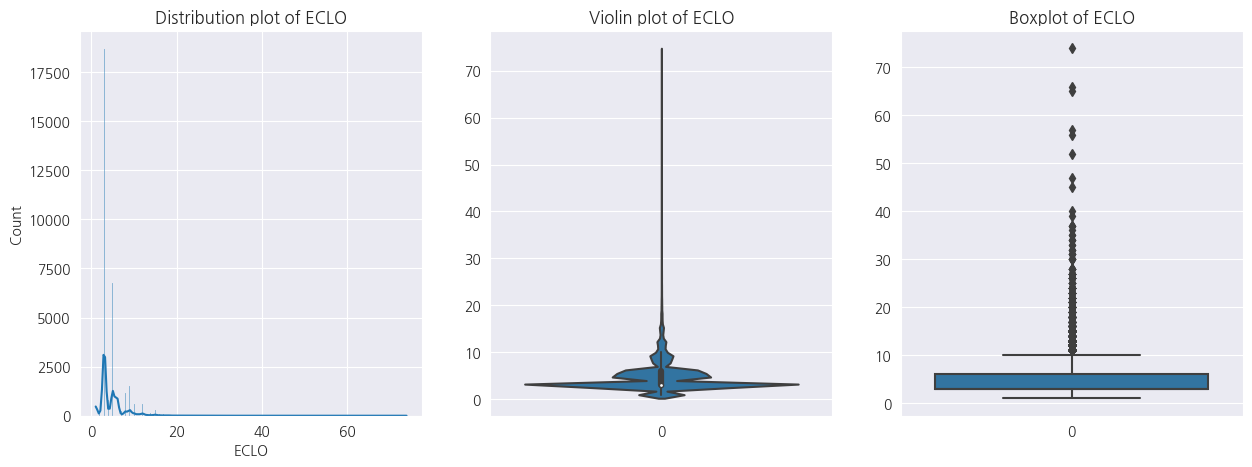

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.histplot(train[target], kde=True, ax=axes[0])
sns.violinplot(train[target], ax=axes[1])
sns.boxplot(train[target], ax=axes[2])

axes[0].set_title(f"Distribution plot of {target}")
axes[1].set_title(f"Violin plot of {target}")
axes[2].set_title(f"Boxplot of {target}")

In [20]:
# categorical 데이터를 컬럼을 담아주겠습니다.
categorical_cols = list(train.select_dtypes(include='object').columns)
print(f"({len(categorical_cols)}): {categorical_cols}")

(18): ['ID', 'datetime', 'dayWeek', 'weather', 'location', 'roadType', 'roadState', 'accidentType', 'accidentType_detail', 'violation', 'modelF', 'genderF', 'ageF', 'injuryF', 'modelV', 'genderV', 'ageV', 'injuryV']


In [19]:
# 가해자, 피해자 정보와 상관 없이 사고 발생 환경 또는 사고 발생 사건 자체에 대한 컬럼을 따로 뽑았습니다.
situation_cols = ['dayWeek', 'weather', 'roadType', 'roadState', 'accidentType', 'accidentType_detail', 'violation']

victim_cols = [col for col in categorical_cols if col.endswith('V')]

/home/jo/anaconda3/envs/ds/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
/home/jo/anaconda3/envs/ds/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


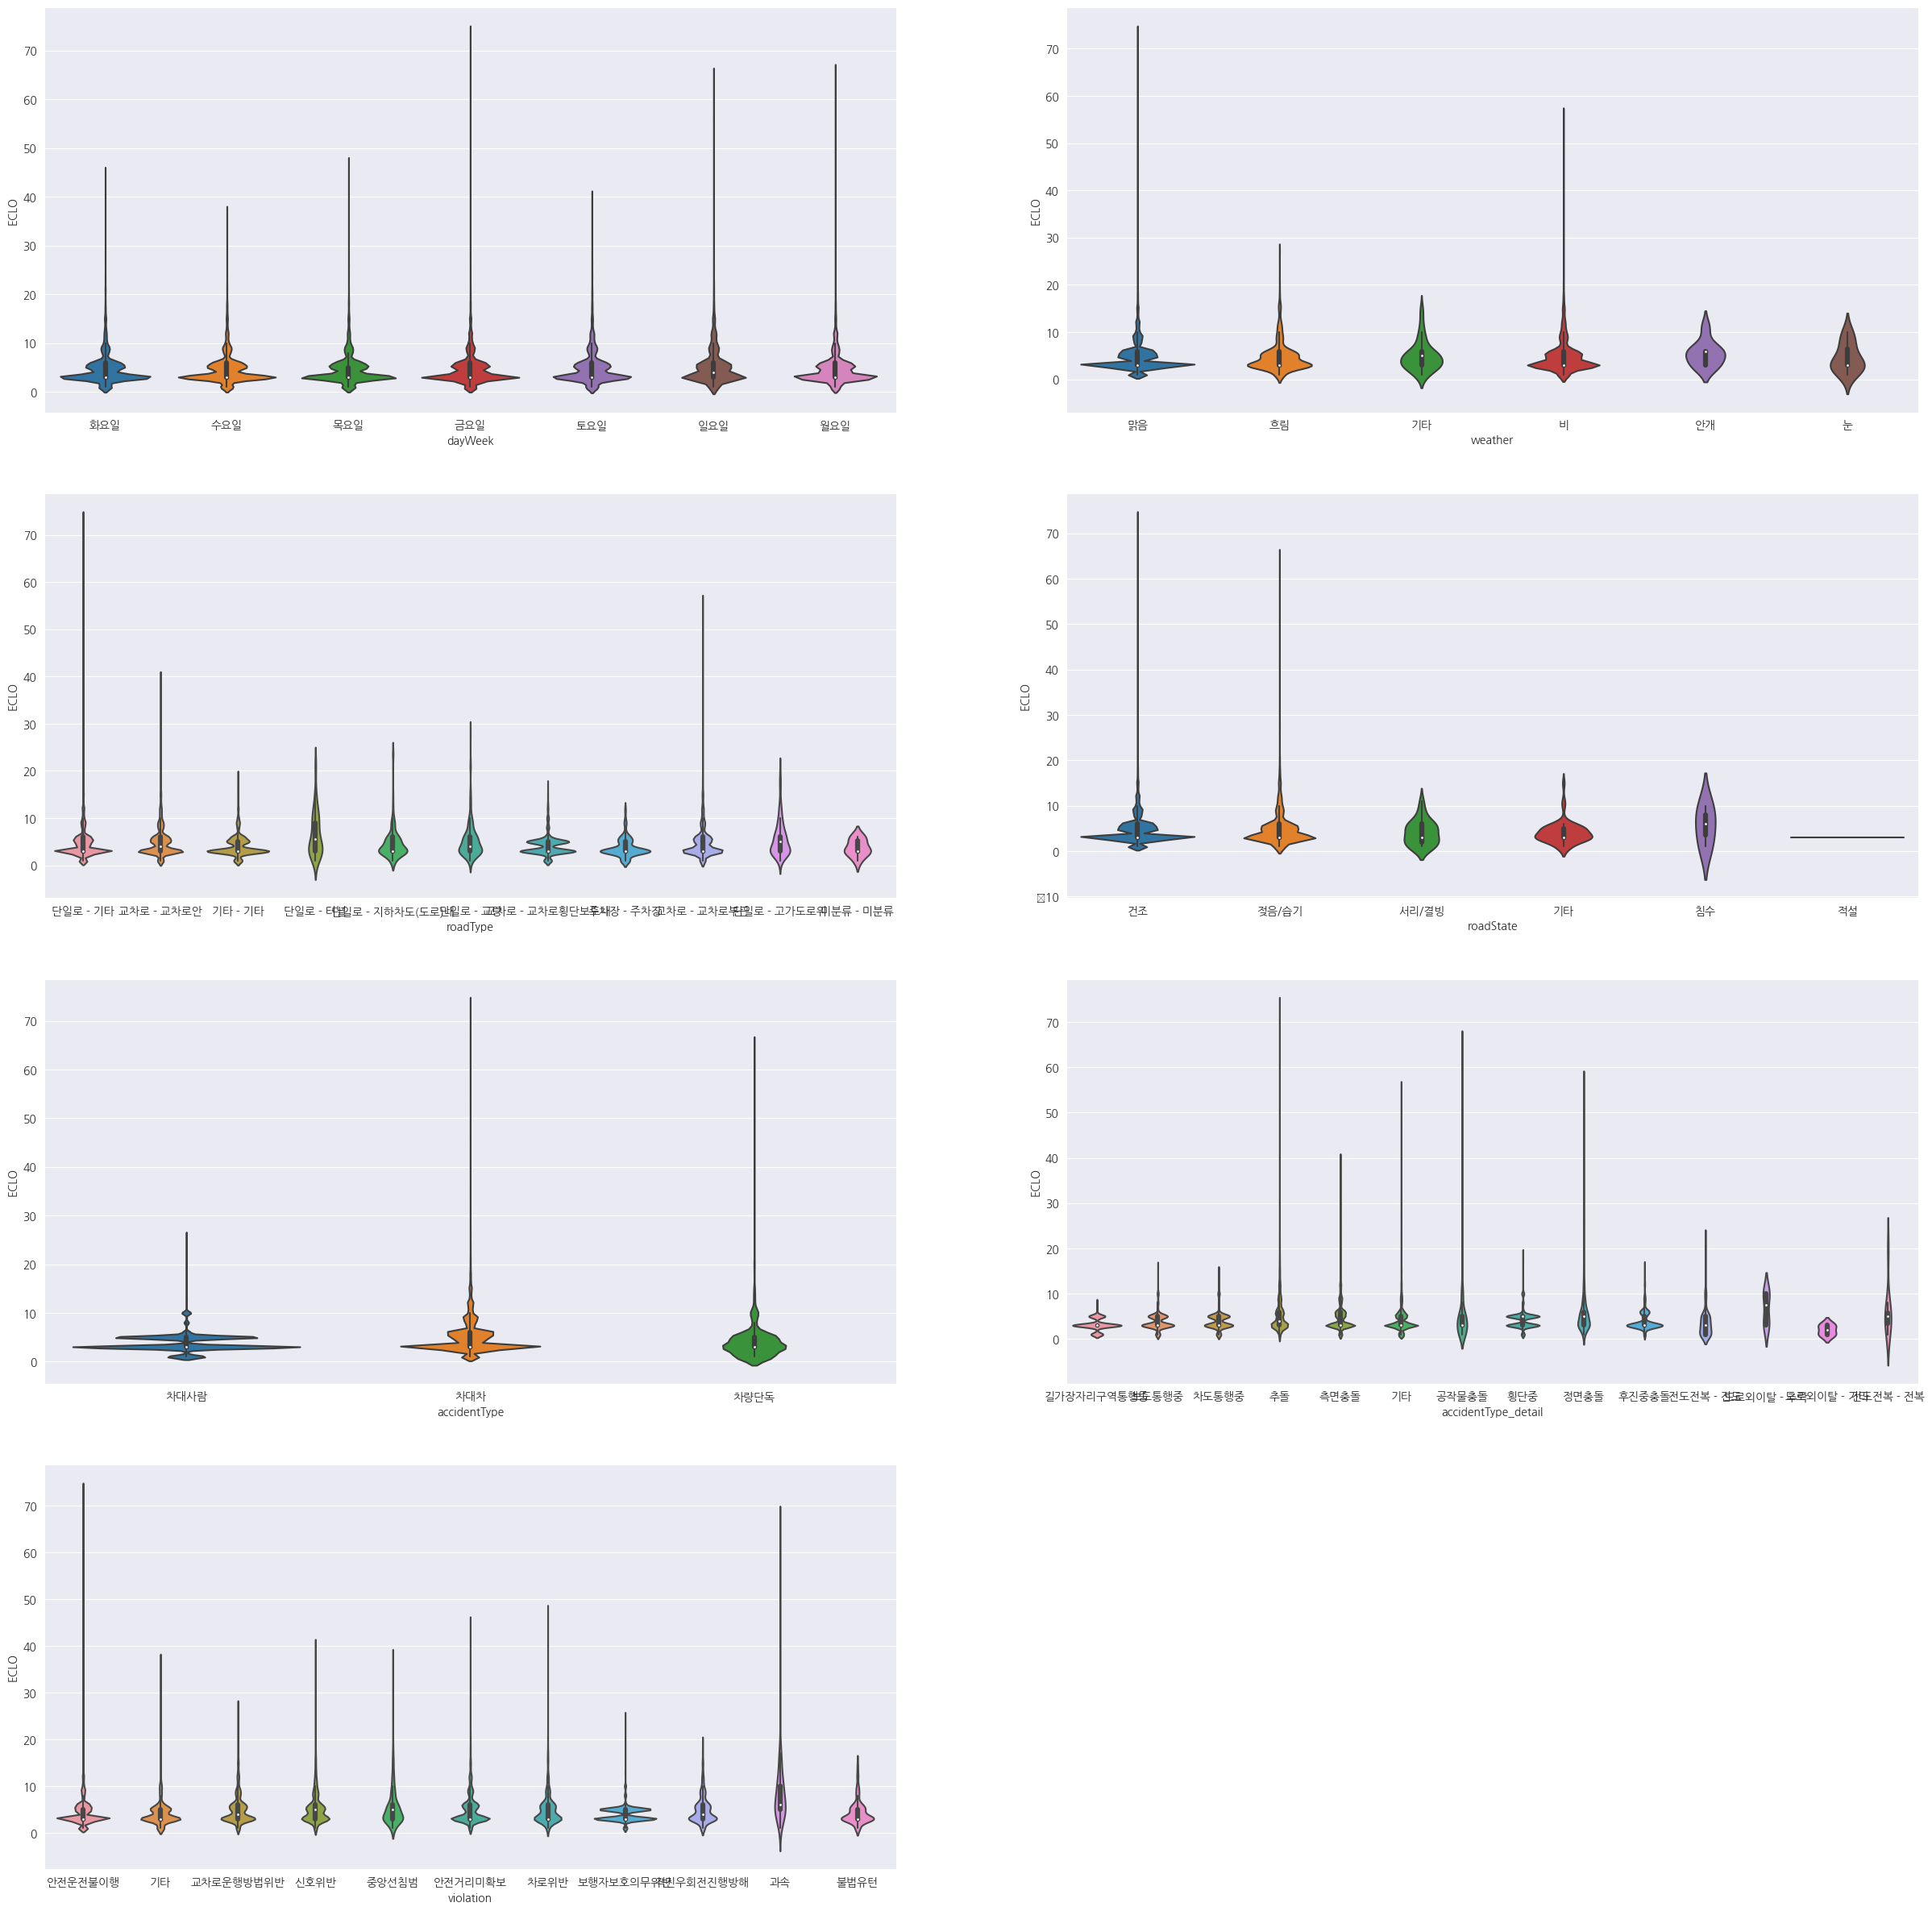

In [28]:
# EDA about situation information
# 요일 별, 날씨 별, 등 상황과 사건에 대한 분포를 보겠습니다.
# fig, axes = plt.subplots(ncols=2, nrows=4, figsize=(30, 25))

plt.subplots(figsize=(30, 30))
plt.clf()

for i, feature in enumerate(situation_cols):
    plt.subplot(4, 2, i+1)
    # sns.barplot(x=train[feature].value_counts().index, y=train[feature].value_counts())
    sns.violinplot(y=target, x=feature, data=train)
    # plt.tight_layout()

- 도로 형태에 따라 ECLO가 다를 것 같기도 합니다.
    - 교차로와 같은 복잡한 도로에서는 큰 사고가 날 것이고, 어둡고 밀폐된 터널에서도 부상자가 많을 것 같습니다.
- 사고 유형에 따른 ECLO도 다를 것 같습니다.
    - 어떤 사고 유형은 부상자가 1~2명 이겠지만, n충 추돌사고일 경우 다수의 부상자가 있을 것 같습니다.

<Axes: xlabel='accidentType_detail', ylabel='ECLO'>

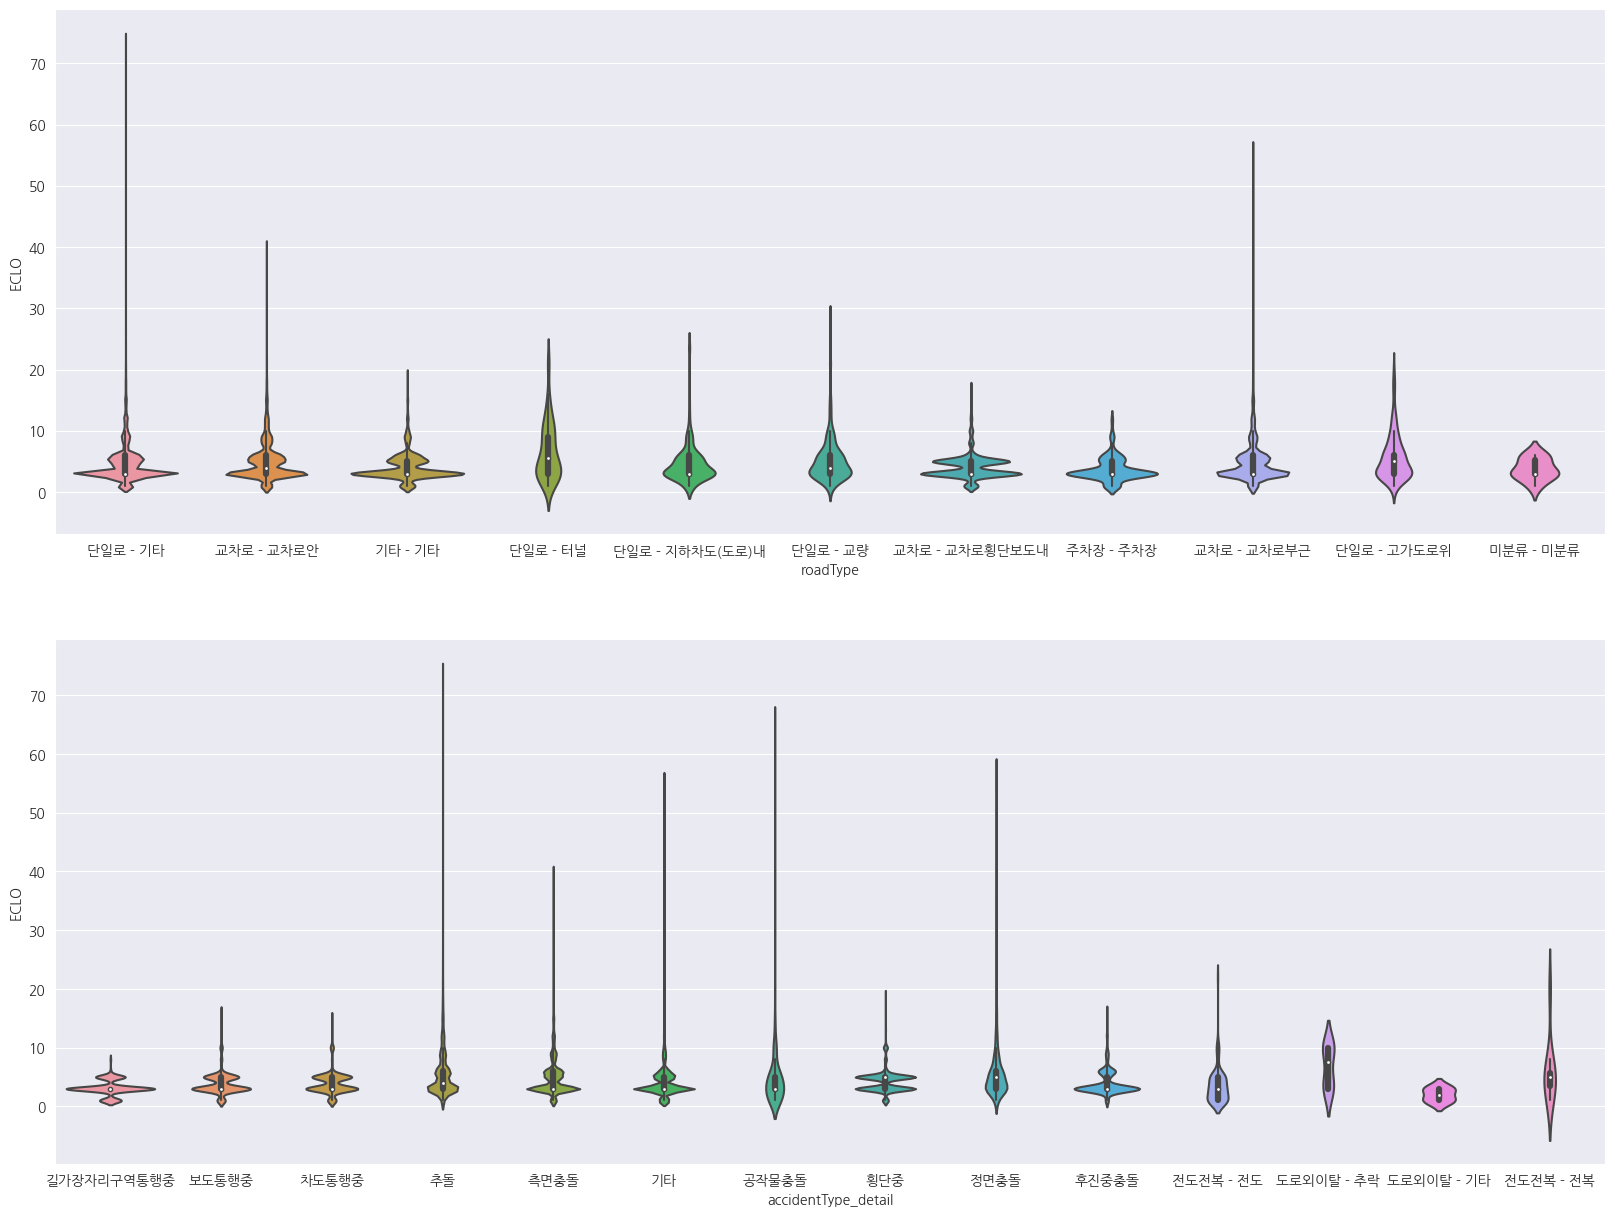

In [27]:
fig, axes = plt.subplots(2,1, figsize=(20, 15))

# avg_rt = train.groupby('roadType')['ECLO'].mean()
# avg_at = train.groupby('accidentType_detail')['ECLO'].mean()
# 
# sns.barplot(x=avg_rt.index, y=avg_rt, ax=axes[0])
# sns.barplot(x=avg_at.index, y=avg_at, ax=axes[1])

sns.violinplot(y=target, x='roadType', data=train, ax=axes[0])
sns.violinplot(y=target, x='accidentType_detail', data=train, ax=axes[1])

# 결과를 보니 부상자 수보다도 사망자의 유무 또는 사망자 수가 확실히 ECLO 값을 결정한다는 걸 알 수 있었습니다. (당연한 얘기지만)

In [29]:
# 연도, 월, 날짜, 시간 별로 쪼개서 보겠습니다.

train['year'] = pd.DatetimeIndex(train['datetime']).year
train['month'] = pd.DatetimeIndex(train['datetime']).month
train['day'] = pd.DatetimeIndex(train['datetime']).day
train['hour'] = pd.DatetimeIndex(train['datetime']).hour

In [30]:
train['datetime'] = pd.to_datetime(train['datetime'])
test['datetime'] = pd.to_datetime(test['datetime'])

train['ageF'] = train['ageF'].apply(lambda x: x.replace('세', ''))
train['ageV'] = train['ageV'].apply(lambda x: x.replace('세', ''))

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39609 entries, 0 to 39608
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ID                   39609 non-null  object        
 1   datetime             39609 non-null  datetime64[ns]
 2   dayWeek              39609 non-null  object        
 3   weather              39609 non-null  object        
 4   location             39609 non-null  object        
 5   roadType             39609 non-null  object        
 6   roadState            39609 non-null  object        
 7   accidentType         39609 non-null  object        
 8   accidentType_detail  39609 non-null  object        
 9   violation            39609 non-null  object        
 10  modelF               39609 non-null  object        
 11  genderF              39609 non-null  object        
 12  ageF                 39609 non-null  object        
 13  injuryF              39609 non-

[Text(0.5, 1.0, 'Number of accidents by location')]

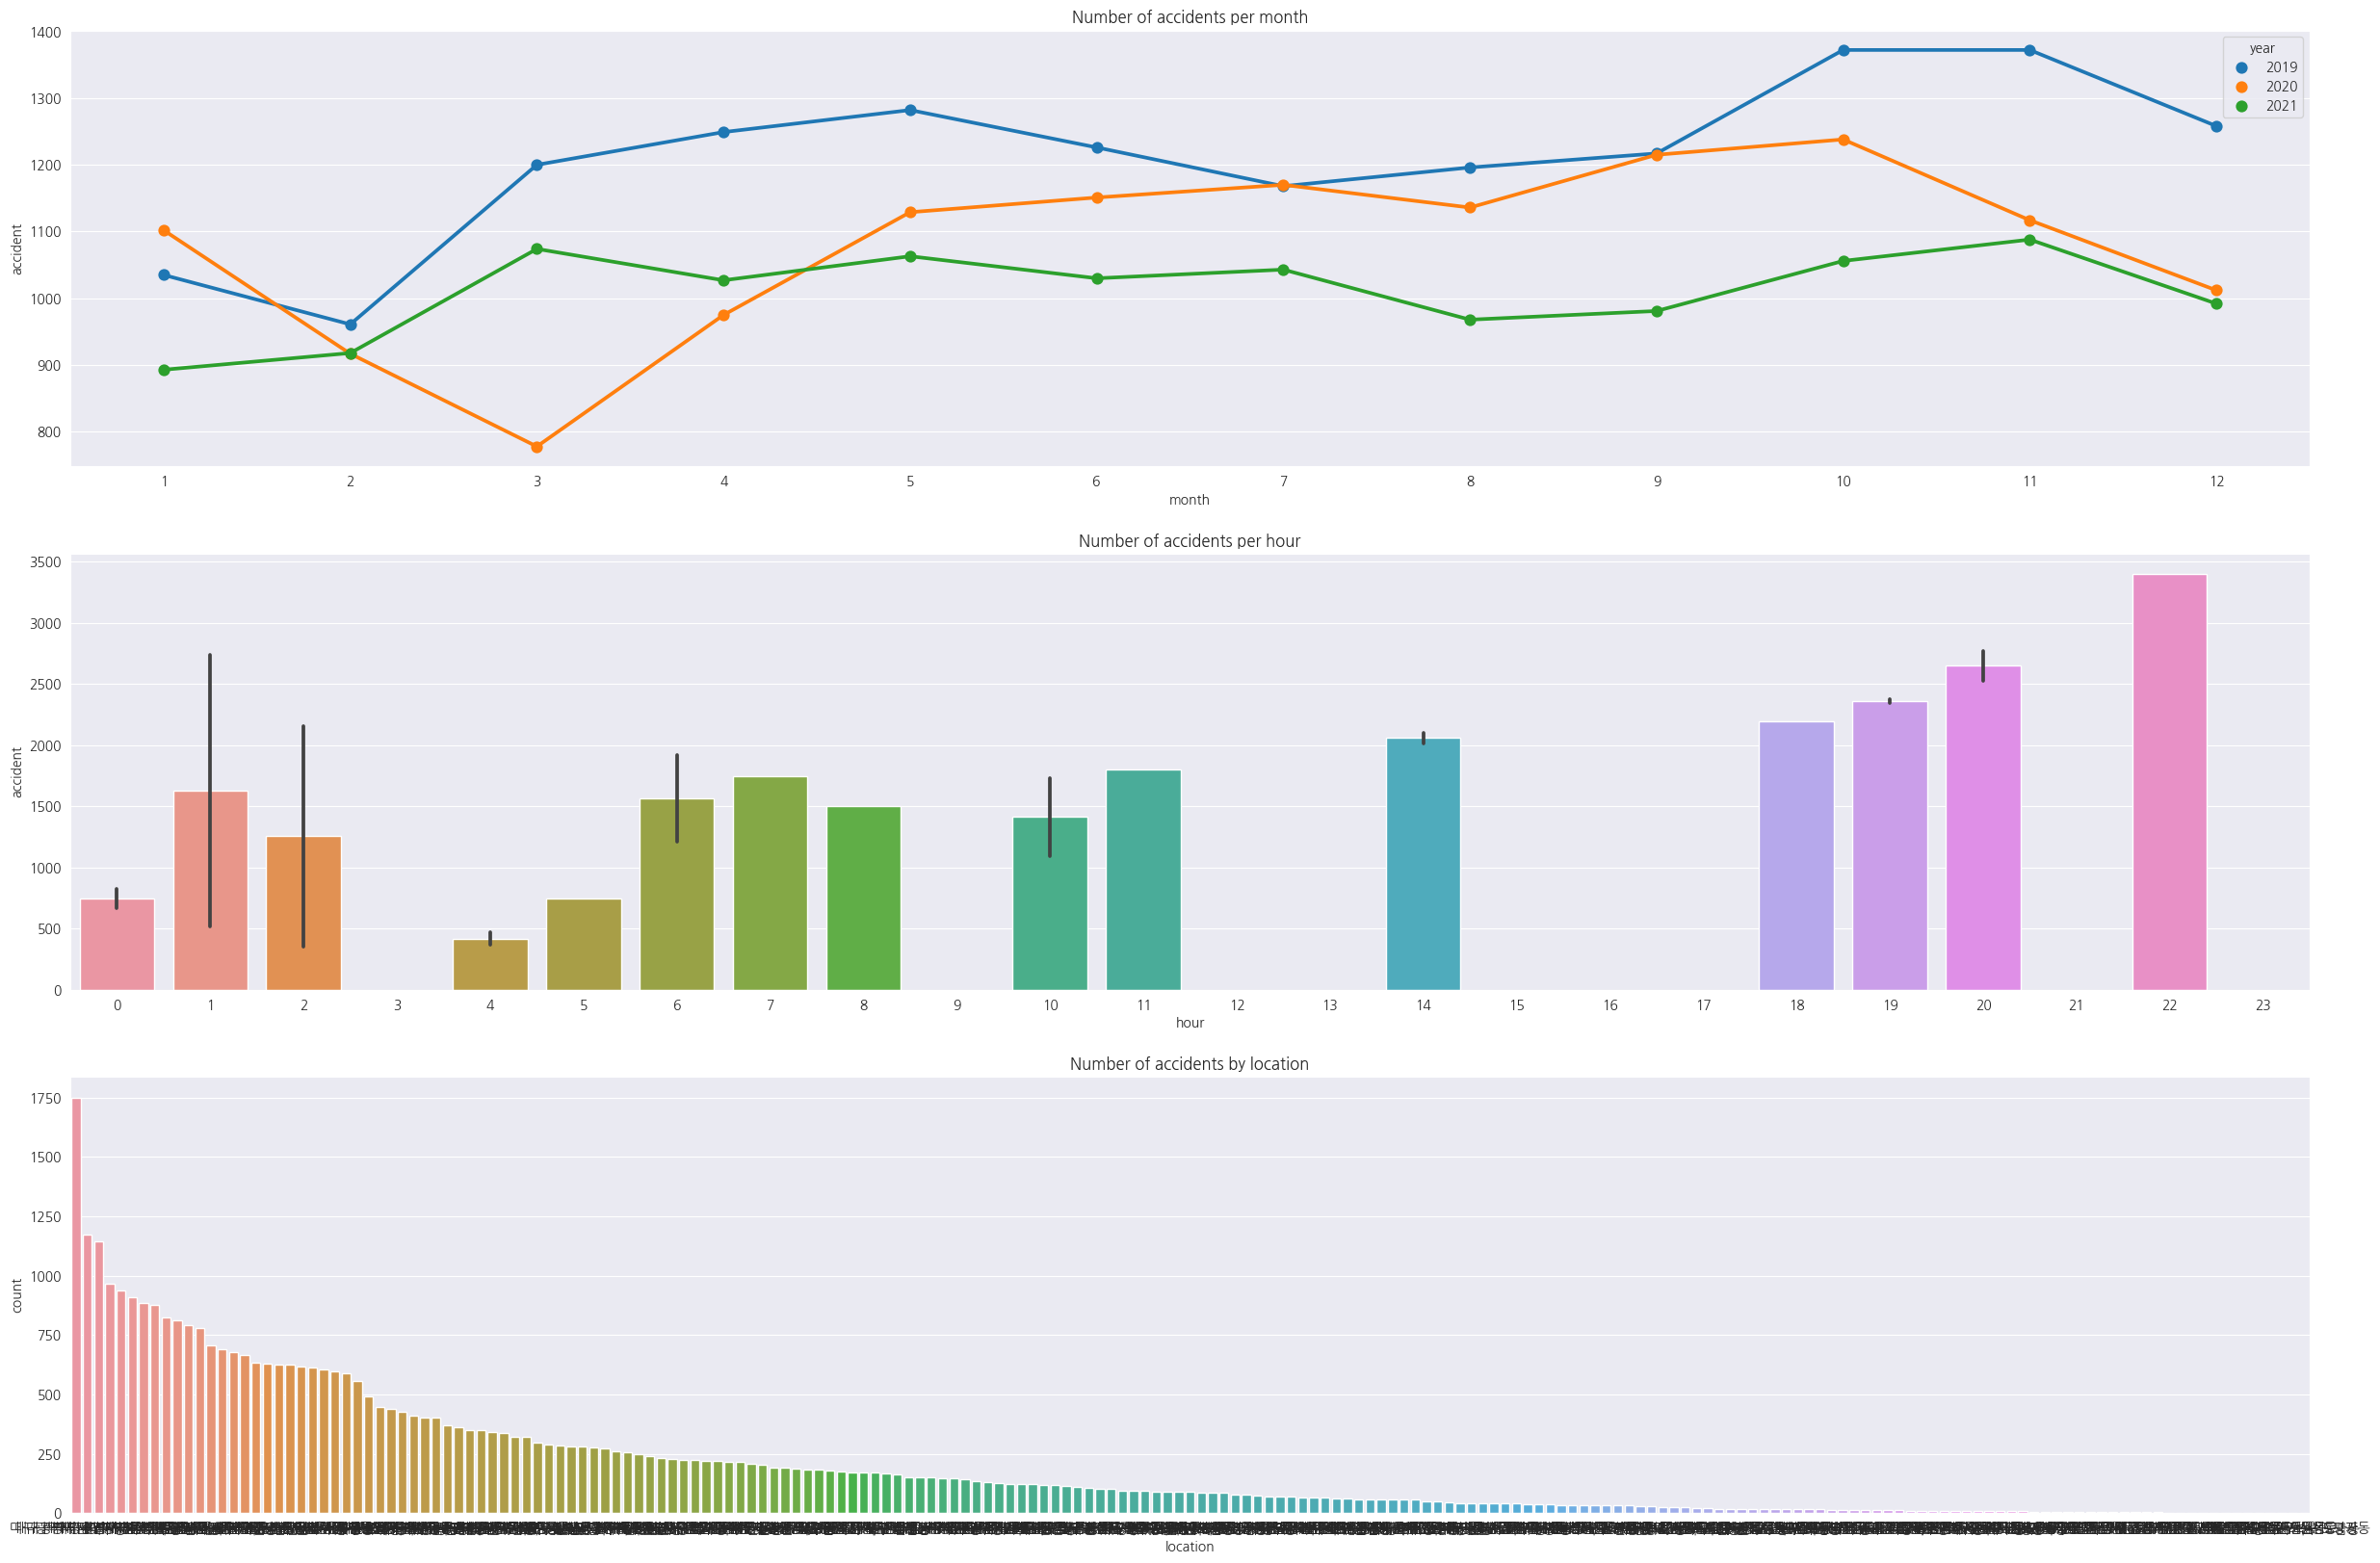

In [39]:
# 월 별, 시간 별 사건 발생 "건수"를 보겠습니다.
# 교통사고가 많이 발생하는 시간대, 기간이 따로 있을까요?
# 예를 들면, 5월에는 소풍, 체험학습을 많이 가니 대형버스 사고가 날 수도 있고, 겨울에는 빙판길 사고가 있을 수 있겠습니다.
# 또는 출근 시간대에는 출근하는 차량들로 인한 자잘한 충돌 사고를 예상할 수 있고, 밤에는 시야 확보가 안되어 사고가 나는 상황을 예상해 볼 수 있겠습니다.

fig, axes = plt.subplots(3, 1, figsize=(30, 20))

counts_month = train.groupby(['year', 'month']).size().reset_index(name='count')

sns.pointplot(x='month', y='count', hue='year', data=counts_month, ax=axes[0]) # 연도 별로는 어떤 변화를 보이는지도 함께 보겠습니다.
sns.barplot(x='hour', y=train.hour.value_counts(), data=train, ax=axes[1])
sns.barplot(x=train.location.value_counts().index, y=train.location.value_counts(), ax=axes[2])

axes[0].set(title='Number of accidents per month', ylabel='accident')
axes[1].set(title='Number of accidents per hour', ylabel='accident')
axes[2].set(title='Number of accidents by location')


<AxesSubplot: xlabel='location', ylabel='ECLO'>

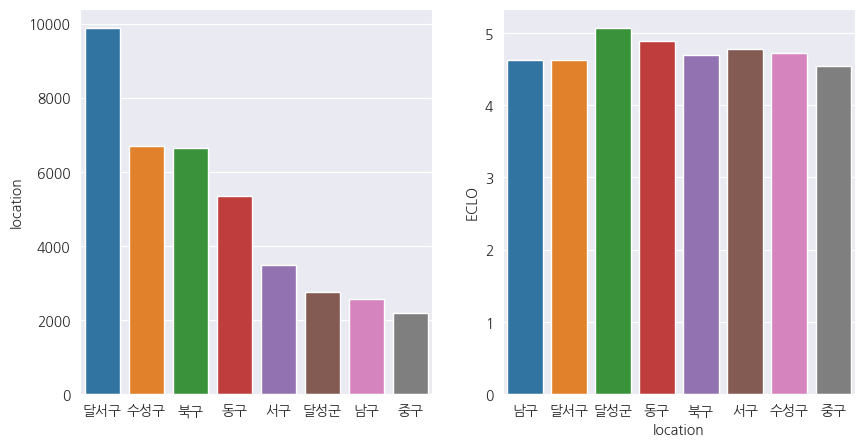

In [206]:
# 보통 혼잡 도시일 수록 사고가 많이 날 것 같은데요. 행정구역이 세분화 되어 있을수록 인구밀도가 높아진다고 합니다.
# 가장 행정구역이 세분화 되어 있는 구를 찾아보고, 해당 구의 평균 ECLO가 가장 높은지 알아보겠습니다.

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

locations_df = train.copy()
locations_df['location'] = locations_df['location'].apply(lambda x: x.split()[1])
sns.barplot(x=locations_df.location.value_counts().index, y=locations_df.location.value_counts(), ax=axes[0]) # 가장 행정구역이 세분화(행정구역이 많은) 구는?
sns.barplot(x=locations_df.groupby(['location'])['ECLO'].mean().index, y=locations_df.groupby(['location'])['ECLO'].mean(), ax=axes[1])

# 가해 운전 차량에 대한 EDA

In [207]:
faulty_cols  = [col for col in categorical_cols if col.endswith('F')]
faulty_cols # 가해 운전 차량과 관련된 컬럼

['modelF', 'genderF', 'ageF', 'injuryF']

## 가해 차량에 대해 궁금한 점
* 앞서 터널에서, 고가도로 위에서, 교량에서 ECLO가 큰 사고가 난다는 걸 알 수 있었고요, 추락사고, 차량 전복과 충돌사고에서 ECLO가 컸습니다.
* 그렇다면 가해 차량의 연령, 차종, 성별에 따른 ECLO는 어떨까요?

[Text(0.5, 1.0, '가해자 부상 종류 별 사고 발생 수')]

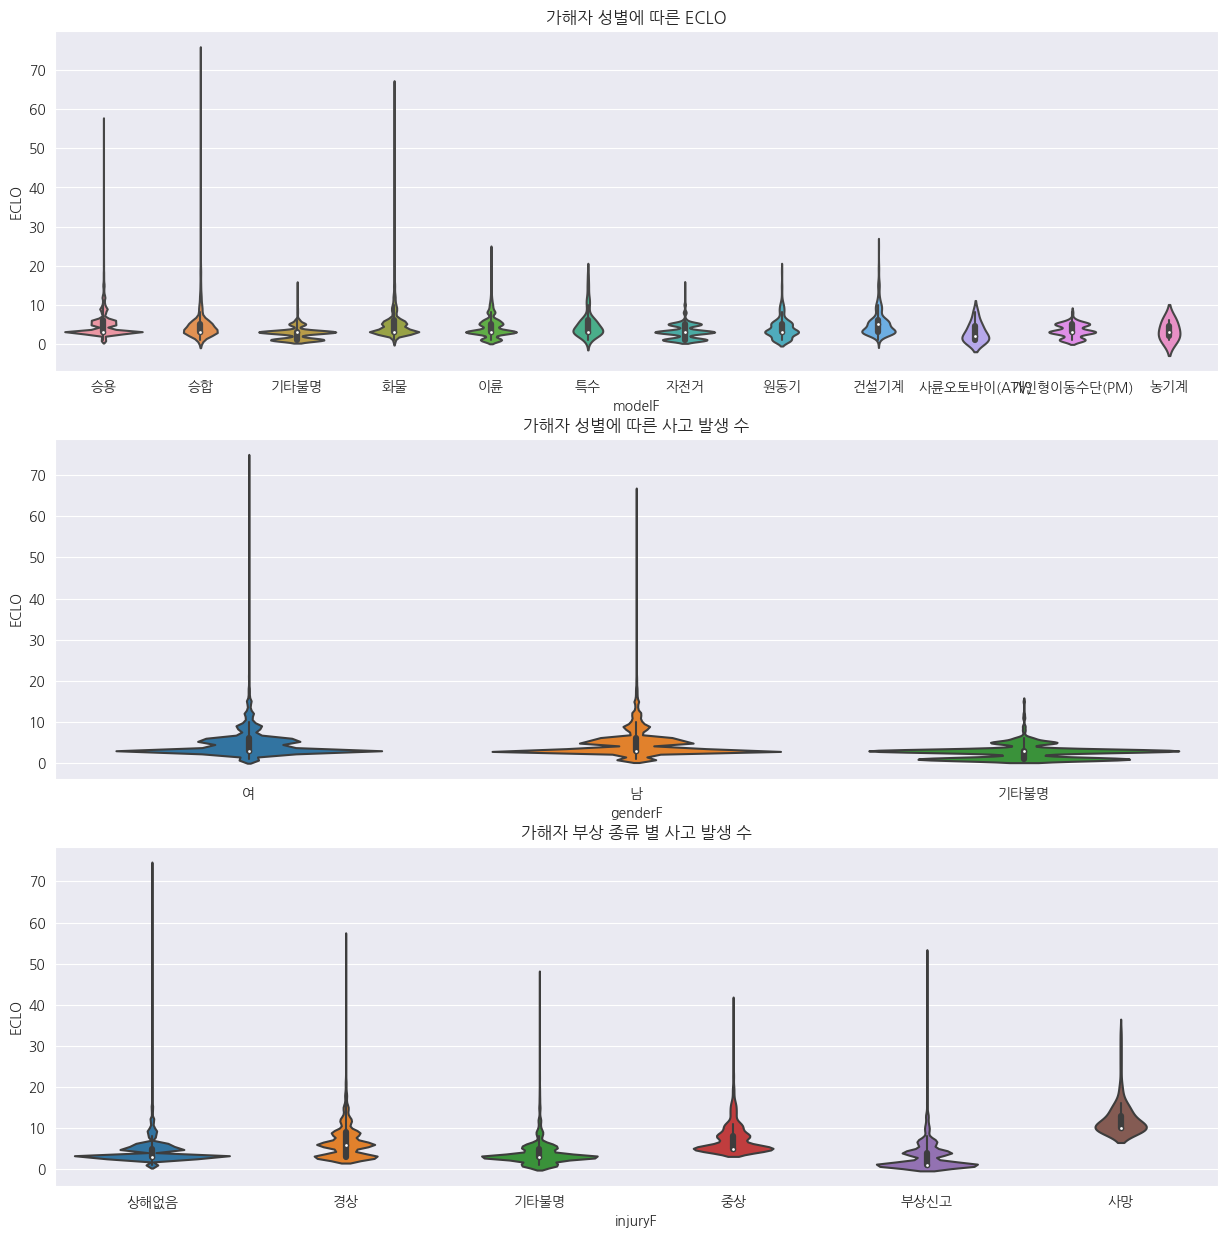

In [45]:
fig, axes = plt.subplots(3, 1, figsize=(15, 15))

avg_modelF = train.groupby('modelF')['ECLO'].mean()
avg_genderF = train.groupby('genderF')['ECLO']
avg_ageF = train.groupby('ageF')['ECLO'].mean()
avg_injuryF = train.groupby('injuryF')['ECLO'].count()

# sns.barplot(x=avg_genderF.mean().index, y=avg_genderF.mean(), ax=axes[0])
# sns.barplot(x=avg_genderF.count().index, y=avg_genderF.count(), ax=axes[1])
# sns.barplot(x=avg_injuryF.index, y=avg_injuryF, ax=axes[2])

sns.violinplot(x='modelF', y=target, data=train, ax=axes[0])
sns.violinplot(x='genderF', y=target, data=train, ax=axes[1])
sns.violinplot(x='injuryF', y=target, data=train, ax=axes[2])


axes[0].set(title="가해자 성별에 따른 ECLO")
axes[1].set(title="가해자 성별에 따른 사고 발생 수")
axes[2].set(title="가해자 부상 종류 별 사고 발생 수")


<AxesSubplot: xlabel='ageF', ylabel='ECLO'>

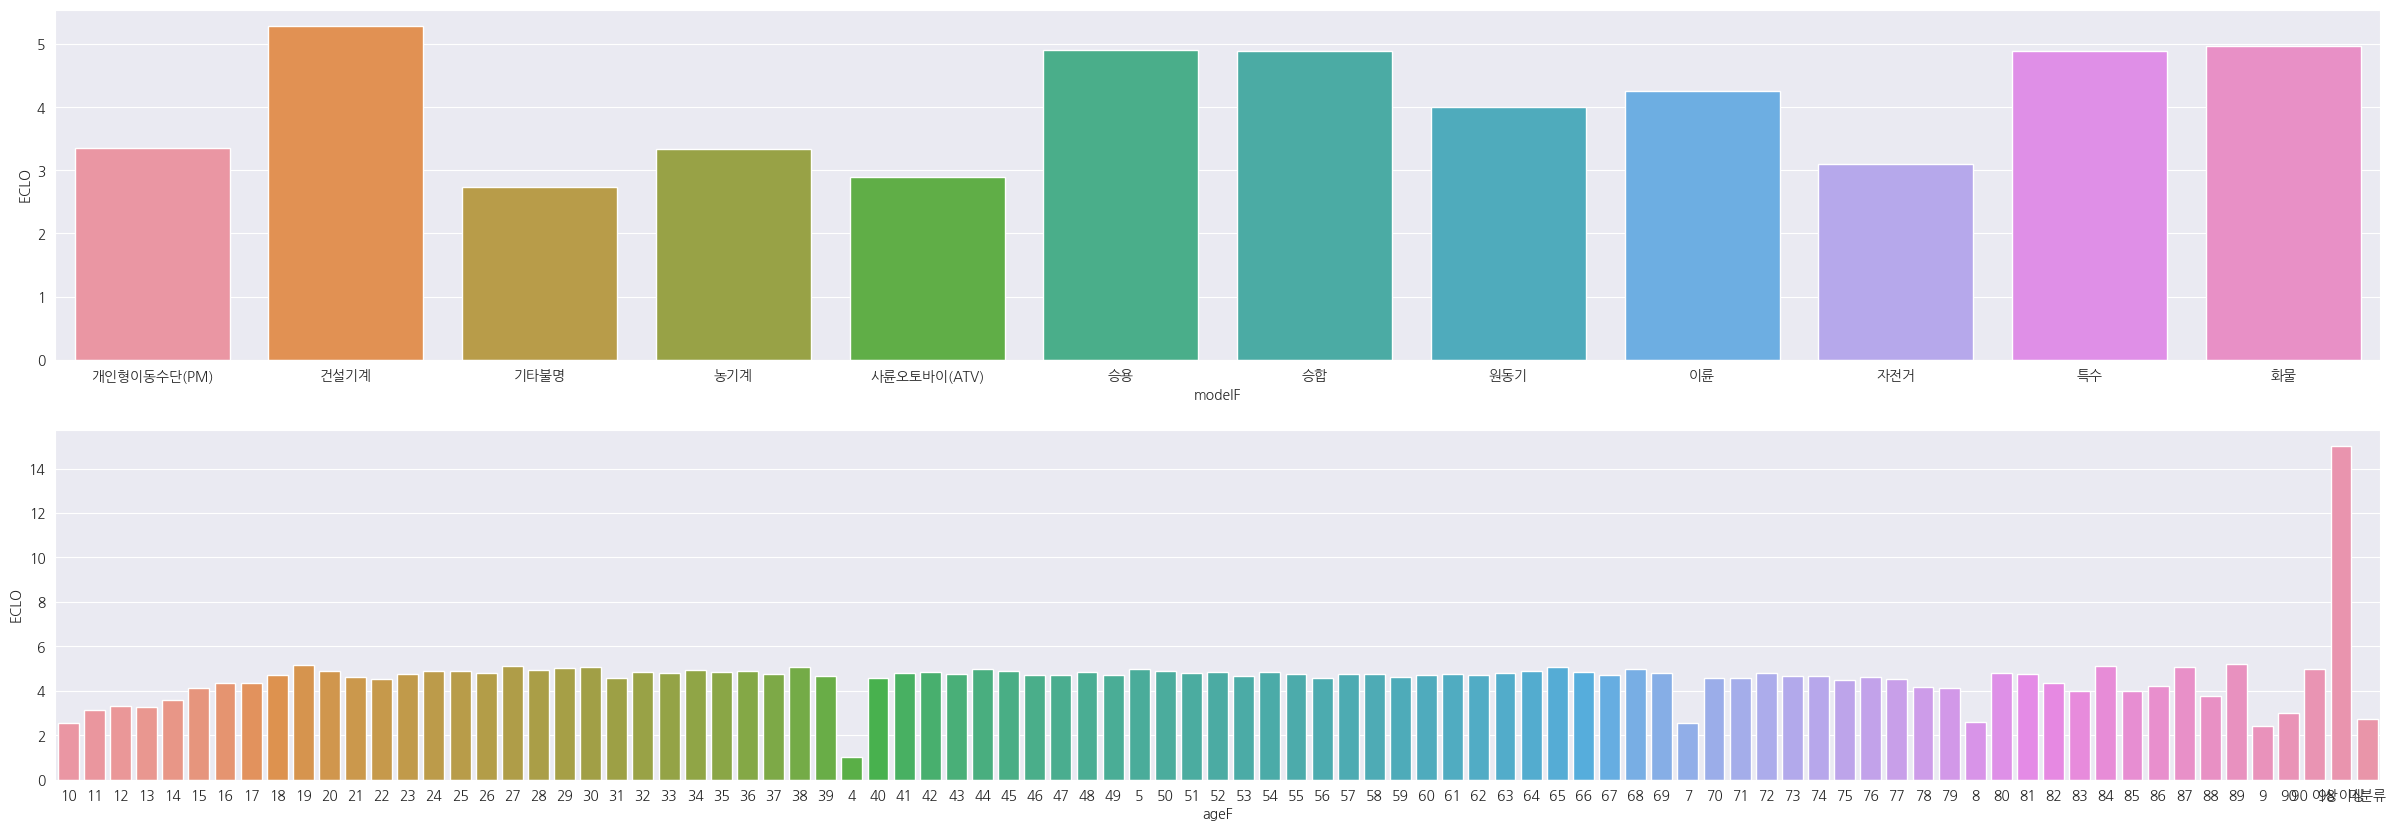

In [209]:
fig, axes = plt.subplots(2, 1, figsize=(30, 10))

sns.barplot(x=avg_modelF.index, y=avg_modelF, ax=axes[0])
sns.barplot(x=avg_ageF.index, y=avg_ageF, ax=axes[1])
# 19세 미만, 그리고 연령대가 높은.. 아무래도 8~90세 이상부터는 가해차량 동승자라고 보는 게 맞을 것 같습니다.

# 피해자에 대한 EDA

In [210]:
victim_cols = [x for x in train.columns if x.endswith('V')]
victim_cols

['modelV', 'genderV', 'ageV', 'injuryV']

[Text(0.5, 1.0, '피해자 부상 종류 별 사고 발생 수')]

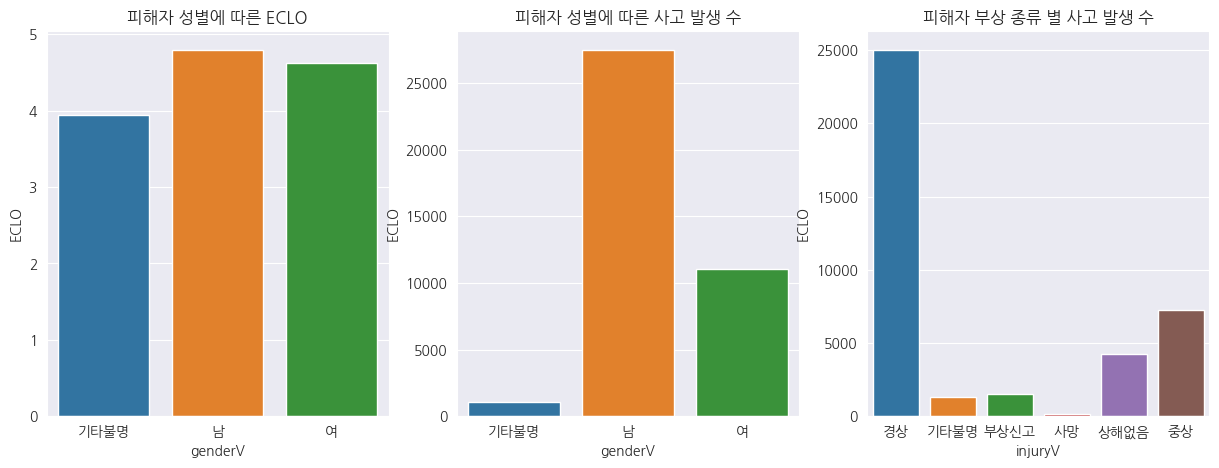

In [211]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

avg_modelV = train.groupby('modelV')['ECLO'].mean()
avg_genderV = train.groupby('genderV')['ECLO']
avg_ageV = train.groupby('ageV')['ECLO'].mean()
avg_injuryV = train.groupby('injuryV')['ECLO'].count()

sns.barplot(x=avg_genderV.mean().index, y=avg_genderV.mean(), ax=axes[0])
sns.barplot(x=avg_genderV.count().index, y=avg_genderV.count(), ax=axes[1])
sns.barplot(x=avg_injuryV.index, y=avg_injuryV, ax=axes[2])

axes[0].set(title="피해자 성별에 따른 ECLO")
axes[1].set(title="피해자 성별에 따른 사고 발생 수")
axes[2].set(title="피해자 부상 종류 별 사고 발생 수")

<AxesSubplot: xlabel='ageV', ylabel='ECLO'>

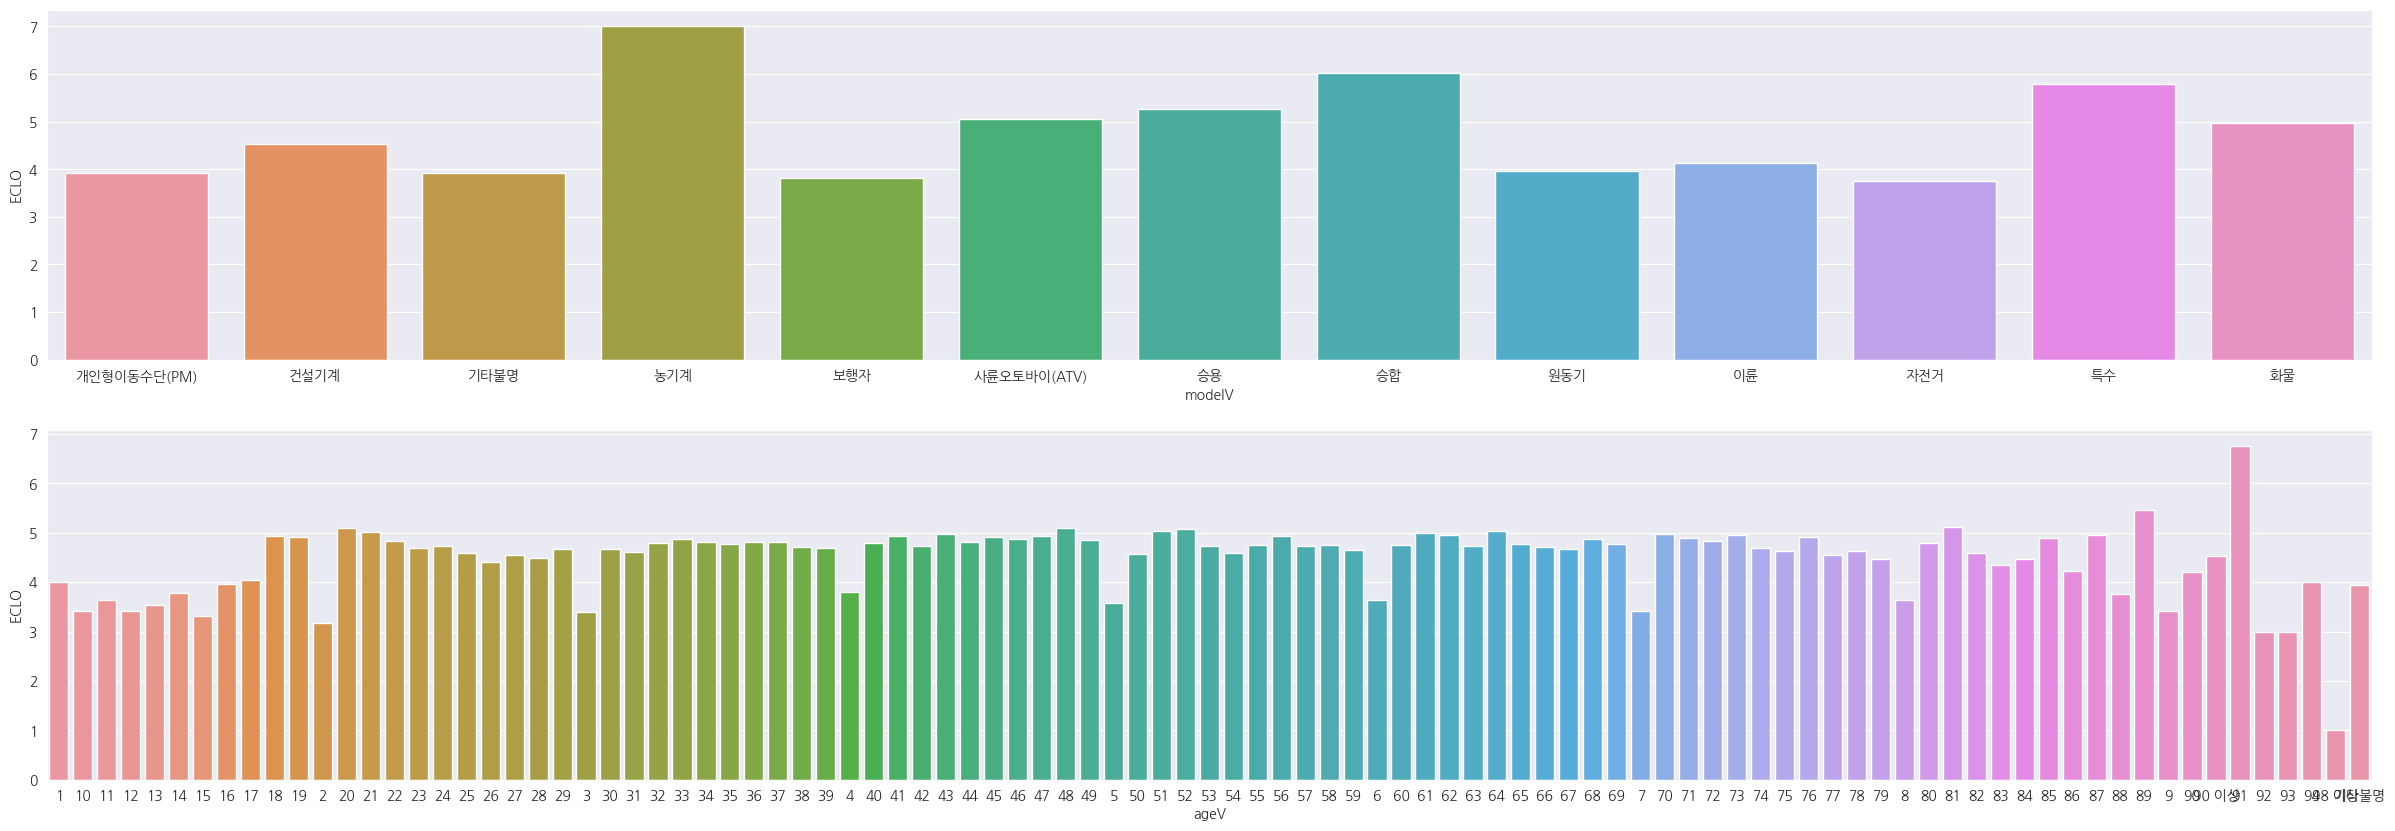

In [212]:
fig, axes = plt.subplots(2, 1, figsize=(30, 10))

sns.barplot(x=avg_modelV.index, y=avg_modelV, ax=axes[0])
sns.barplot(x=avg_ageV.index, y=avg_ageV, ax=axes[1])

# External data

* 제공된 외부 데이터를 활용해 보겠습니다.
* 내용을 살펴 봤을 때, 어떻게 합치는 게 좋을지 저에게는 어려웠습니다...
* 일단은, 소재지 지번주소를 가지고 지역 별 CCTV 수, 보안등 수, 어린이 보호구역 수를 train, test 데이터에 넣어 살펴보는 방법을 선택했습니다.

In [213]:
# cctvs
# security_lights
# school_zones
# parking_lots
cctvs.sample(10)

,무인교통단속카메라관리번호,시도명,시군구명,도로종류,도로노선번호,도로노선명,도로노선방향,소재지도로명주소,소재지지번주소,위도,경도,설치장소,단속구분,제한속도,단속구간위치구분,과속단속구간길이,보호구역구분,설치연도
679,G3284,대구광역시,남구,특별시도,NaN,효성로,2,대구광역시 남구 효성로 71,대구광역시 남구 봉덕동 1292-40,35.839683,128.596843,봉덕초등학교정문(봉명네거리→경일여고교차로),2,30,NaN,NaN,2.0,2019.0
484,F9314,대구광역시,북구,특별시도,33,복현로,1,NaN,대구광역시 북구 복현동 539-136,35.905045,128.619457,문성초등학교앞삼거리(성화여고→검단R),2,30,NaN,NaN,2.0,2017.0
507,F9732,대구광역시,수성구,특별시도,NaN,앞산터널로,2,대구광역시 수성구 앞산터널로 503,대구광역시 수성구 파동 546-1,35.809952,128.613370,앞산터널입구2차로(파동→상인동),99,80,1.0,NaN,99.0,2017.0
33,주차45,대구광역시,남구,시도,NaN,이천로,3,NaN,대구광역시 남구 대명동 2014-478,35.852788,128.594467,영선노인복지센터앞,4,0,NaN,NaN,2.0,2021.0
844,G9084,대구광역시,서구,특별시도,NaN,국채보상로,2,대구광역시 서구 국채보상로 257,대구광역시 서구 평리동 1230-9,35.872322,128.559235,서구청(서대구전화국→신평리네거리),1,50,NaN,NaN,99.0,2021.0
813,G8256,대구광역시,달성군,특별시도,30,가창로,1,대구광역시 달성군 가창면 가창로 640,대구광역시 달성군 가창면 대일리 370-1,35.771051,128.648247,가창초교앞(대일교차로→스파밸리네거리),2,50,NaN,NaN,2.0,2020.0
289,121,대구광역시,달서구,구도,NaN,달서대로,3,대구광역시 달서구 달서대로 39,대구광역시 달서구 유천동 327-1,35.812574,128.511855,유천초등학교 부근,4,0,NaN,NaN,2.0,2021.0
223,36,대구광역시,달서구,구도,NaN,계대동문로,3,대구광역시 달서구 계대동문로 16,대구광역시 달서구 신당동 1790-10,35.855372,128.493951,계명대 농협 부근,4,0,NaN,NaN,NaN,2013.0
200,63,대구광역시,달서구,구도,NaN,송현로,3,대구광역시 달서구 송현로 81,대구광역시 달서구 송현동 898-4,35.824064,128.542984,효성초등학교,4,0,NaN,NaN,2.0,2017.0
857,G9097,대구광역시,동구,특별시도,NaN,화랑로,1,대구광역시 동구 화랑로 558,대구광역시 동구 용계동 965-6,35.874333,128.684651,아인유치원앞(동대구IC→율하역),2,60,NaN,NaN,2.0,2021.0


In [214]:
cctvs.loc[328] = "대구광역시 중구 남성로 92"
cctvs.loc[738] = "대구광역시 중구 동인동4가 89-1"
cctvs[cctvs['소재지지번주소'].isna()] # null값이 두 개 뿐이라서 직접 입력해 주었습니다.

,무인교통단속카메라관리번호,시도명,시군구명,도로종류,도로노선번호,도로노선명,도로노선방향,소재지도로명주소,소재지지번주소,위도,경도,설치장소,단속구분,제한속도,단속구간위치구분,과속단속구간길이,보호구역구분,설치연도


In [215]:
cctvs['location'] = cctvs['소재지지번주소'].apply(lambda x: ' '.join(str(x).split()[:3])) # train, test 데이터의 사고발생 시군구는 시,구,동/읍/면 정도까지만 제공됩니다. 따라서 이 형식을 따라주도록 하겠습니다.

cctv_locations = cctvs['location']
cctv_locations

0        대구광역시 남구 대명동
1        대구광역시 남구 봉덕동
2        대구광역시 남구 봉덕동
3        대구광역시 남구 대명동
4        대구광역시 남구 봉덕동
            ...      
1060     대구광역시 북구 구암동
1061     대구광역시 북구 사수동
1062     대구광역시 북구 대현동
1063     대구광역시 북구 대현동
1064    대구광역시 달서구 두류동
Name: location, Length: 1065, dtype: object

In [216]:
security_lights[security_lights['소재지지번주소'].isna()] # 지번주소가 없는 경우 찾기 -> 0개!!

,보안등위치명,설치개수,소재지도로명주소,소재지지번주소,위도,경도,설치연도,설치형태


In [217]:
security_lights['location'] = security_lights['소재지지번주소'].apply(lambda x: ' '.join(str(x).split()[:3]))
light_locations = security_lights['location']

In [218]:
school_zones[school_zones['소재지지번주소'].isna()] # 85개..........................

,시설종류,대상시설명,소재지도로명주소,소재지지번주소,위도,경도,관리기관명,관할경찰서명,CCTV설치여부,CCTV설치대수,보호구역도로폭,데이터기준일자
238,초등학교,효동초교,대구광역시 동구 효동로 78-7,NaN,35.884122,128.644739,대구광역시청,대구동부경찰서,Y,2.0,6,2020-01-14
239,초등학교,율하초교,대구광역시 동구 율하동로15길 1,NaN,35.867814,128.701537,대구광역시청,대구동부경찰서,Y,2.0,6,2020-01-14
240,초등학교,반야월초교,대구광역시 동구 안심로49길 70,NaN,35.868274,128.710762,대구광역시청,대구동부경찰서,Y,2.0,6,2020-01-14
241,초등학교,동촌초교,대구광역시 동구 동촌로 168,NaN,35.882087,128.658952,대구광역시청,대구동부경찰서,Y,1.0,8,2020-01-14
242,초등학교,신천초교,대구광역시 동구 송라로6길 5,NaN,35.871649,128.621009,대구광역시청,대구동부경찰서,Y,2.0,6,2020-01-14
...,...,...,...,...,...,...,...,...,...,...,...,...
318,유치원,숲에온유치원,대구광역시 동구 신암북로 11길 11,NaN,35.888055,128.621959,대구광역시청,대구동부경찰서,Y,1.0,8,2020-01-14
319,유치원,으뜸유치원,대구광역시 동구 위남로2길 38,NaN,35.930736,128.634983,대구광역시청,대구동부경찰서,Y,1.0,6,2020-01-14
320,유치원,위즈숲유치원,대구광역시 동구 파계로19길 12-7,NaN,35.942592,128.636003,대구광역시청,대구동부경찰서,Y,1.0,6,2020-01-14
321,유치원,수피아유치원,대구광역시 동구 메디벨리로8길 11,NaN,35.884158,128.717342,대구광역시청,대구동부경찰서,Y,1.0,12,2020-01-14


### 소재지 지번주소 없음

* 데이터 중 소재지 지번주소가 없는 경우가 있었습니다. 활용 가능한 외부 데이터 중 공공데이터포털이 추가되어, 공공데이터포털에서 제공되는 행정안전부 실시간 주소정보 조회 검색 API를 활용했습니다.

In [219]:
# 행정안전부 API

def get_address(roadAddress, confmKey='devU01TX0FVVEgyMDIzMTEyMTE3MTQyNTExNDI5NTQ='):
    url = 'https://business.juso.go.kr/addrlink/addrLinkApi.do'
    
    query_params = {
        'confmKey': confmKey,
        'currentPage': 1,
        'countPerPage': 10,
        'keyword': roadAddress,
        'resultType': 'json'
    }
    response = requests.get(url, query_params)
    if response.status_code == 200:
        data = response.json()
        return data['results']['juso'][0]['jibunAddr']
    else:
        print(f"Failed to fetch data. Status code: {response.status_code}")
jibunAddress = get_address(roadAddress="대구광역시 동구 안심로49길 70")

In [220]:
for index, row in school_zones[school_zones['소재지지번주소'].isna()].iterrows(): # 데이터프레임을 돌며 지번주소가 없는 경우, 도로명 주소를 통해 지번주소를 검색하도록 합니다.
    try:
        address = get_address(row['소재지도로명주소'])
        school_zones.loc[index]['소재지지번주소'] = address
        # print(index, address)
    except: pass
    

/tmp/ipykernel_536691/2343759905.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  school_zones.loc[index]['소재지지번주소'] = address


In [221]:
sz = school_zones.dropna(subset=['소재지지번주소']) # 지번주소를 찾을 수 없는 경우 drop합니다.
print(sz.shape, school_zones.shape) # 얼만큼의 데이터가 소실됐는지 확인합니다.

(555, 12) (640, 12)


In [222]:
sz['location'] = sz['소재지지번주소'].apply(lambda x: ' '.join(str(x).split()[:3]))

/tmp/ipykernel_536691/2243358408.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sz['location'] = sz['소재지지번주소'].apply(lambda x: ' '.join(str(x).split()[:3]))


In [223]:
cctv_df = pd.Series(cctvs.groupby('location')['location'].count(), name='cctvs')
light_df = pd.Series(security_lights.groupby('location')['location'].count(), name='securityLights')
sz_df = pd.Series(sz.groupby('location')['location'].count(), name='schoolZones')
# 모은 external data를 모아주겠습니다.
external_df = pd.concat([cctv_df, light_df, sz_df], axis=1, join='outer')
external_df.fillna(0, inplace=True) # Null 값은 없다는 뜻이라고 보고 0으로 채워주겠습니다.
external_df

,cctvs,securityLights,schoolZones
location,,,
대구 달성군 가창면,2.0,0.0,0.0
대구 달성군 구지면,1.0,0.0,0.0
대구 달성군 다사읍,8.0,0.0,0.0
대구 달성군 옥포읍,6.0,0.0,0.0
대구 달성군 유가읍,3.0,0.0,0.0
...,...,...,...
대구광역시 중구 화전동,0.0,22.0,0.0
대구광역시 수성구 노변동,0.0,0.0,5.0
대구광역시 수성구 사월동,0.0,0.0,2.0


In [224]:
train_df = train.copy()
test_df = test.copy()

In [225]:
external_df.reset_index(inplace=True) # index가 location으로 되어 있어 rest해주겠습니다.

<AxesSubplot: >

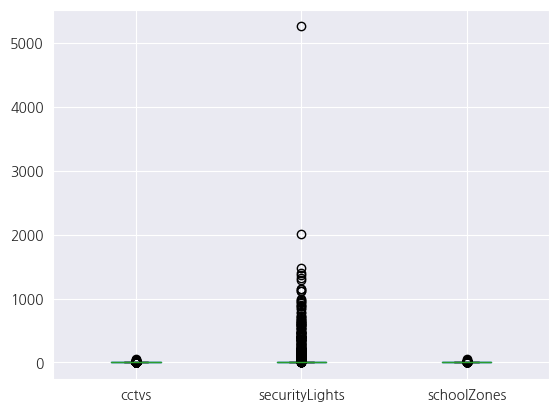

In [226]:
external_df.boxplot() # 모든 데이터에 설치 장소 및 주소가 있었으니 이상치로 보지는 않겠습니다.

In [261]:
train_df = pd.merge(left=train, right=external_df, how="left")
test_df = pd.merge(left=test, right=external_df, how="left")

In [262]:
print(train_df.shape, train.shape)

(39609, 30) (39609, 27)


In [263]:
train_df.fillna(0, inplace=True)

In [264]:
test_df.fillna(0, inplace=True)

In [235]:
train_df.to_csv('../dataset/DaeguTrafficAccident/train_.csv', index=False)
test_df.to_csv('../dataset/DaeguTrafficAccident/test_.csv', index=False)

[Text(0.5, 1.0, 'Changes in ECLO according to the number of school zones'),
 Text(0.5, 0, 'number of school zones')]

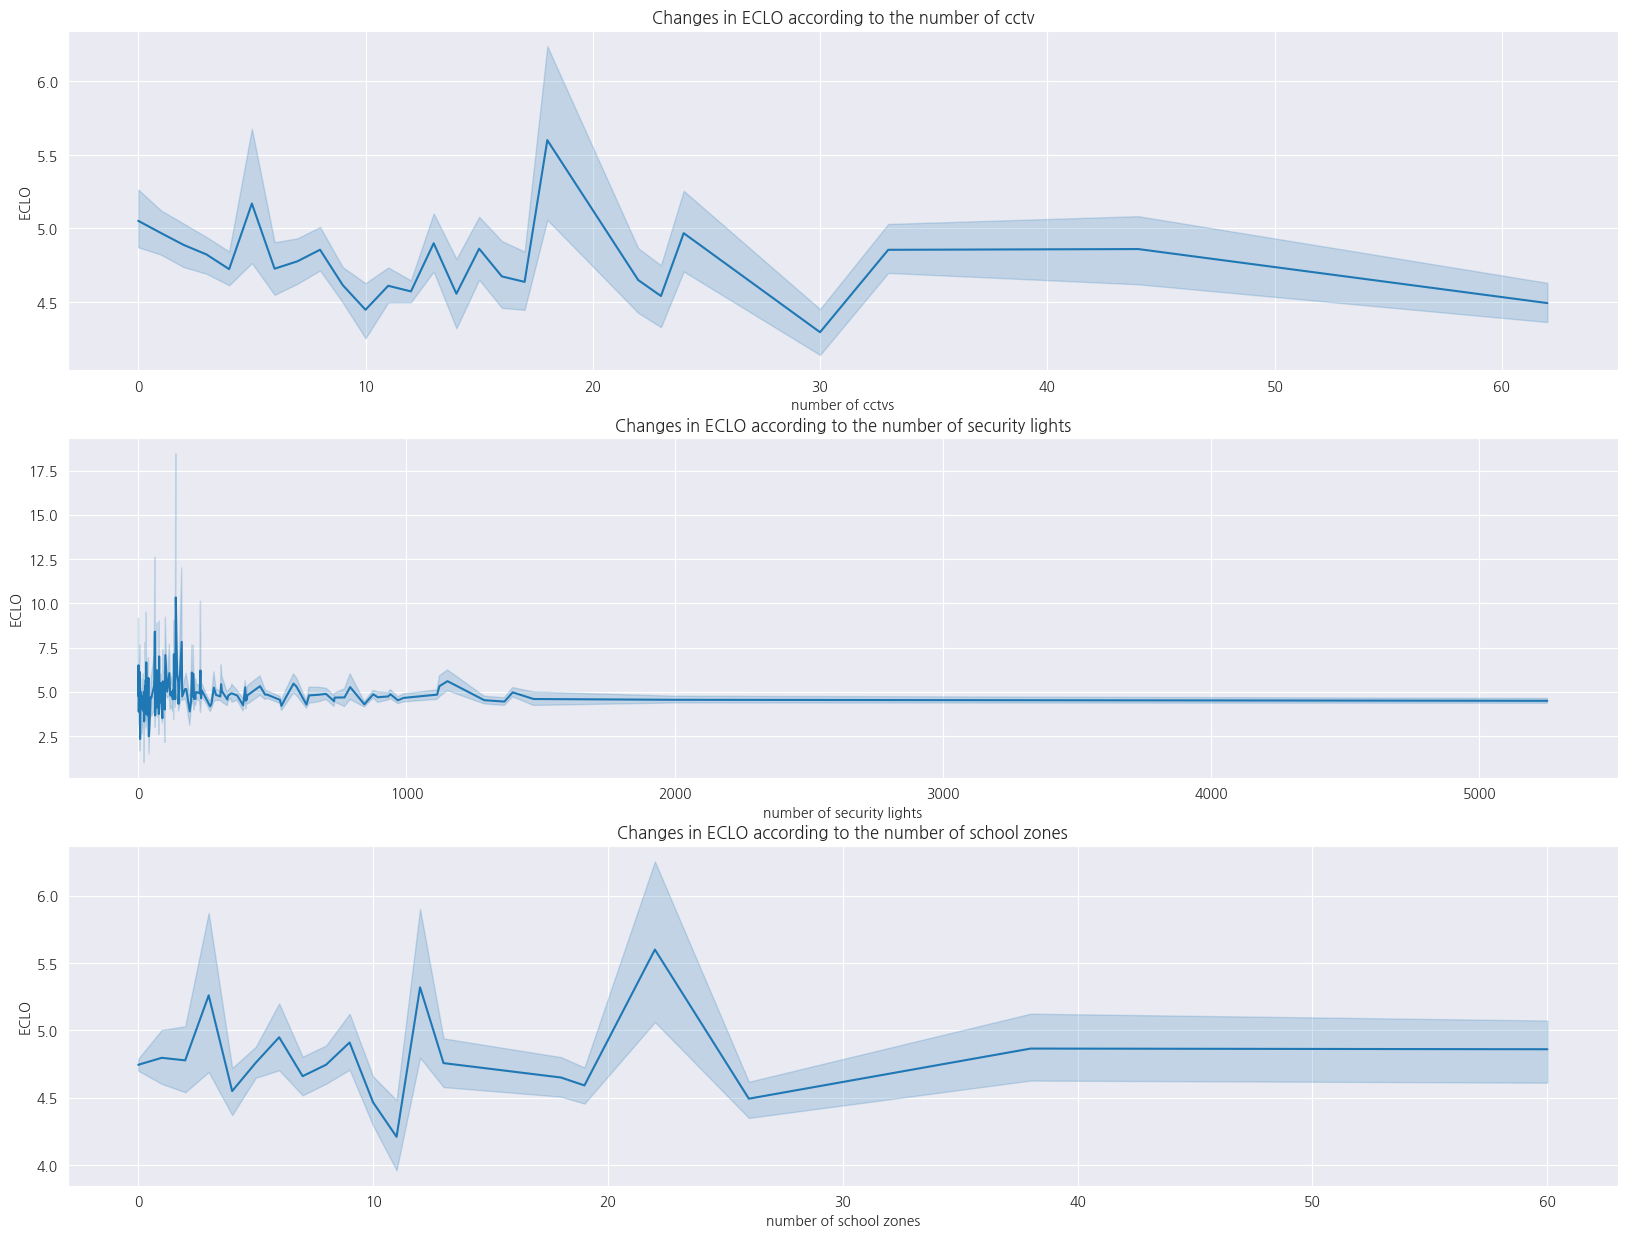

In [236]:
# CCTV 수가 많을수록, 보안등이 많을수록, 어린이 보호구역이 많을수록 안전할까요?
# 또는, 안전하지 않을수록 CCTV 수가, 보안등이 많을까요?, 어린이 보호구역에서 사고가 많이 날까요?

fig, axes = plt.subplots(3, 1, figsize=(20, 15))


sns.lineplot(x='cctvs', y='ECLO', data=train_df, ax=axes[0])
sns.lineplot(x='securityLights', y='ECLO', data=train_df, ax=axes[1])
sns.lineplot(x='schoolZones', y='ECLO', data=train_df, ax=axes[2])

axes[0].set(title="Changes in ECLO according to the number of cctv", xlabel='number of cctvs')
axes[1].set(title="Changes in ECLO according to the number of security lights", xlabel='number of security lights')
axes[2].set(title="Changes in ECLO according to the number of school zones", xlabel='number of school zones')

In [238]:
submission = pd.read_csv('../dataset/DaeguTrafficAccident/sample_submission.csv')
submission.shape

(10963, 2)

In [259]:
from sklearn.preprocessing import StandardScaler
numeric_cols = [col for col in train_df.columns if train_df[col].dtype == 'float64']

for col in numeric_cols:
    scaler = StandardScaler()
    scaler.fit(train_df[col].values.reshape(-1,1))
    train_df[col] = scaler.transform(train_df[col].values.reshape(-1,1))
    test_df[col] = scaler.transform(test_df[col].values.reshape(-1,1))

In [244]:
# [col for col in train_df.columns if train_df[col].dtype == 'float64']
[col for col in train_df.columns if train_df[col].dtype == 'float64']

['cctvs', 'securityLights', 'schoolZones']

In [246]:
type(train_df['cctvs'])

pandas.core.series.Series

In [247]:
t = pd.read_csv('../dataset/DaeguTrafficAccident/test.csv')
t.sample()

,ID,사고일시,요일,기상상태,시군구,도로형태,노면상태,사고유형
2295,ACCIDENT_41904,2022-03-28 17,월요일,맑음,대구광역시 동구 동호동,교차로 - 교차로안,건조,차대차


In [274]:
countrywide_accidents.sample()

,ID,datetime,dayWeek,weather,location,roadType,roadState,accidentType,accidentType_detail,violation,...,injuryF,modelV,genderV,ageV,injuryV,death,injuredS,injuredL,injured,ECLO
509106,COUNTRYWIDE_ACCIDENT_509106,2021-07-09 19,금요일,맑음,서울특별시 서초구 방배동,단일로 - 기타,건조,차대차,측면충돌,교차로운행방법위반,...,상해없음,승용,남,43세,중상,0,2,0,0,10


In [273]:
countrywide_accidents.columns = ['ID', 'datetime', 'dayWeek', 'weather', 'location',
                                 'roadType', 'roadState',
                                 'accidentType', 'accidentType_detail',
                                 'violation',
                                 'modelF', 'genderF', 'ageF', 'injuryF', # drive at Fault의 F
                                 'modelV', 'genderV', 'ageV', 'injuryV', # victim의 V
                                 'death', 'injuredS', 'injuredL', 'injured', # injuredS: Severly injured, injuredL: Lightly injured
                                 'ECLO']

In [275]:
tr = pd.read_csv('../dataset/DaeguTrafficAccident/train.csv')
ca = pd.read_csv('../dataset/DaeguTrafficAccident/external_open/countrywide_accident.csv')

In [279]:
train_added = pd.concat([tr, ca])

train_added.shape

(642384, 23)

In [280]:
print(tr.shape, ca.shape)

(39609, 23) (602775, 23)


In [281]:
train_added.to_csv('../dataset/DaeguTrafficAccident/train_with_countrywide.csv', index=False)

In [282]:
train_added = pd.read_csv('../dataset/DaeguTrafficAccident/train_with_countrywide.csv')

In [285]:
train_added.tail(10)

,ID,사고일시,요일,기상상태,시군구,도로형태,노면상태,사고유형,사고유형 - 세부분류,법규위반,...,가해운전자 상해정도,피해운전자 차종,피해운전자 성별,피해운전자 연령,피해운전자 상해정도,사망자수,중상자수,경상자수,부상자수,ECLO
642374,COUNTRYWIDE_ACCIDENT_602765,2021-12-31 23,금요일,맑음,충청남도 예산군 삽교읍,교차로 - 교차로안,건조,차대사람,기타,안전운전불이행,...,상해없음,보행자,남,40세,중상,0,1,0,0,5
642375,COUNTRYWIDE_ACCIDENT_602766,2021-12-31 23,금요일,맑음,서울특별시 서초구 반포동,단일로 - 기타,건조,차대사람,기타,안전운전불이행,...,상해없음,보행자,여,27세,경상,0,0,1,0,3
642376,COUNTRYWIDE_ACCIDENT_602767,2021-12-31 23,금요일,맑음,경기도 안산시 상록구 본오동,교차로 - 교차로부근,건조,차대차,추돌,안전운전불이행,...,상해없음,승용,남,52세,경상,0,1,3,0,14
642377,COUNTRYWIDE_ACCIDENT_602768,2021-12-31 23,금요일,맑음,경기도 이천시 장록동,단일로 - 기타,건조,차량단독,공작물충돌,안전운전불이행,...,경상,NaN,NaN,NaN,NaN,0,0,1,0,3
642378,COUNTRYWIDE_ACCIDENT_602769,2021-12-31 23,금요일,맑음,부산광역시 연제구 연산동,단일로 - 기타,건조,차대차,기타,안전운전불이행,...,상해없음,자전거,여,57세,중상,0,1,0,0,5
642379,COUNTRYWIDE_ACCIDENT_602770,2021-12-31 23,금요일,흐림,부산광역시 해운대구 우동,교차로 - 교차로안,건조,차대차,기타,신호위반,...,상해없음,승합,남,52세,상해없음,0,1,1,0,8
642380,COUNTRYWIDE_ACCIDENT_602771,2021-12-31 23,금요일,맑음,서울특별시 성동구 행당동,단일로 - 기타,건조,차대차,측면충돌,안전거리미확보,...,상해없음,승용,남,71세,경상,0,0,2,0,6
642381,COUNTRYWIDE_ACCIDENT_602772,2021-12-31 23,금요일,맑음,대전광역시 유성구 원신흥동,교차로 - 교차로안,건조,차대차,측면충돌,안전운전불이행,...,상해없음,승용,남,56세,경상,0,0,3,0,9
642382,COUNTRYWIDE_ACCIDENT_602773,2021-12-31 23,금요일,맑음,경기도 화성시 서신면,기타 - 기타,젖음/습기,차량단독,기타,안전운전불이행,...,부상신고,NaN,NaN,NaN,NaN,0,0,0,1,1
642383,COUNTRYWIDE_ACCIDENT_602774,2021-12-31 23,금요일,맑음,경기도 파주시 와동동,단일로 - 기타,건조,차대차,측면충돌,안전운전불이행,...,경상,승용,여,51세,경상,0,0,2,0,6


In [287]:
train_added.columns = ['ID', 'datetime', 'dayWeek', 'weather', 'location',
                                 'roadType', 'roadState',
                                 'accidentType', 'accidentType_detail',
                                 'violation',
                                 'modelF', 'genderF', 'ageF', 'injuryF', # drive at Fault의 F
                                 'modelV', 'genderV', 'ageV', 'injuryV', # victim의 V
                                 'death', 'injuredS', 'injuredL', 'injured', # injuredS: Severly injured, injuredL: Lightly injured
                                 'ECLO']

<AxesSubplot: xlabel='accidentType_detail', ylabel='ECLO'>

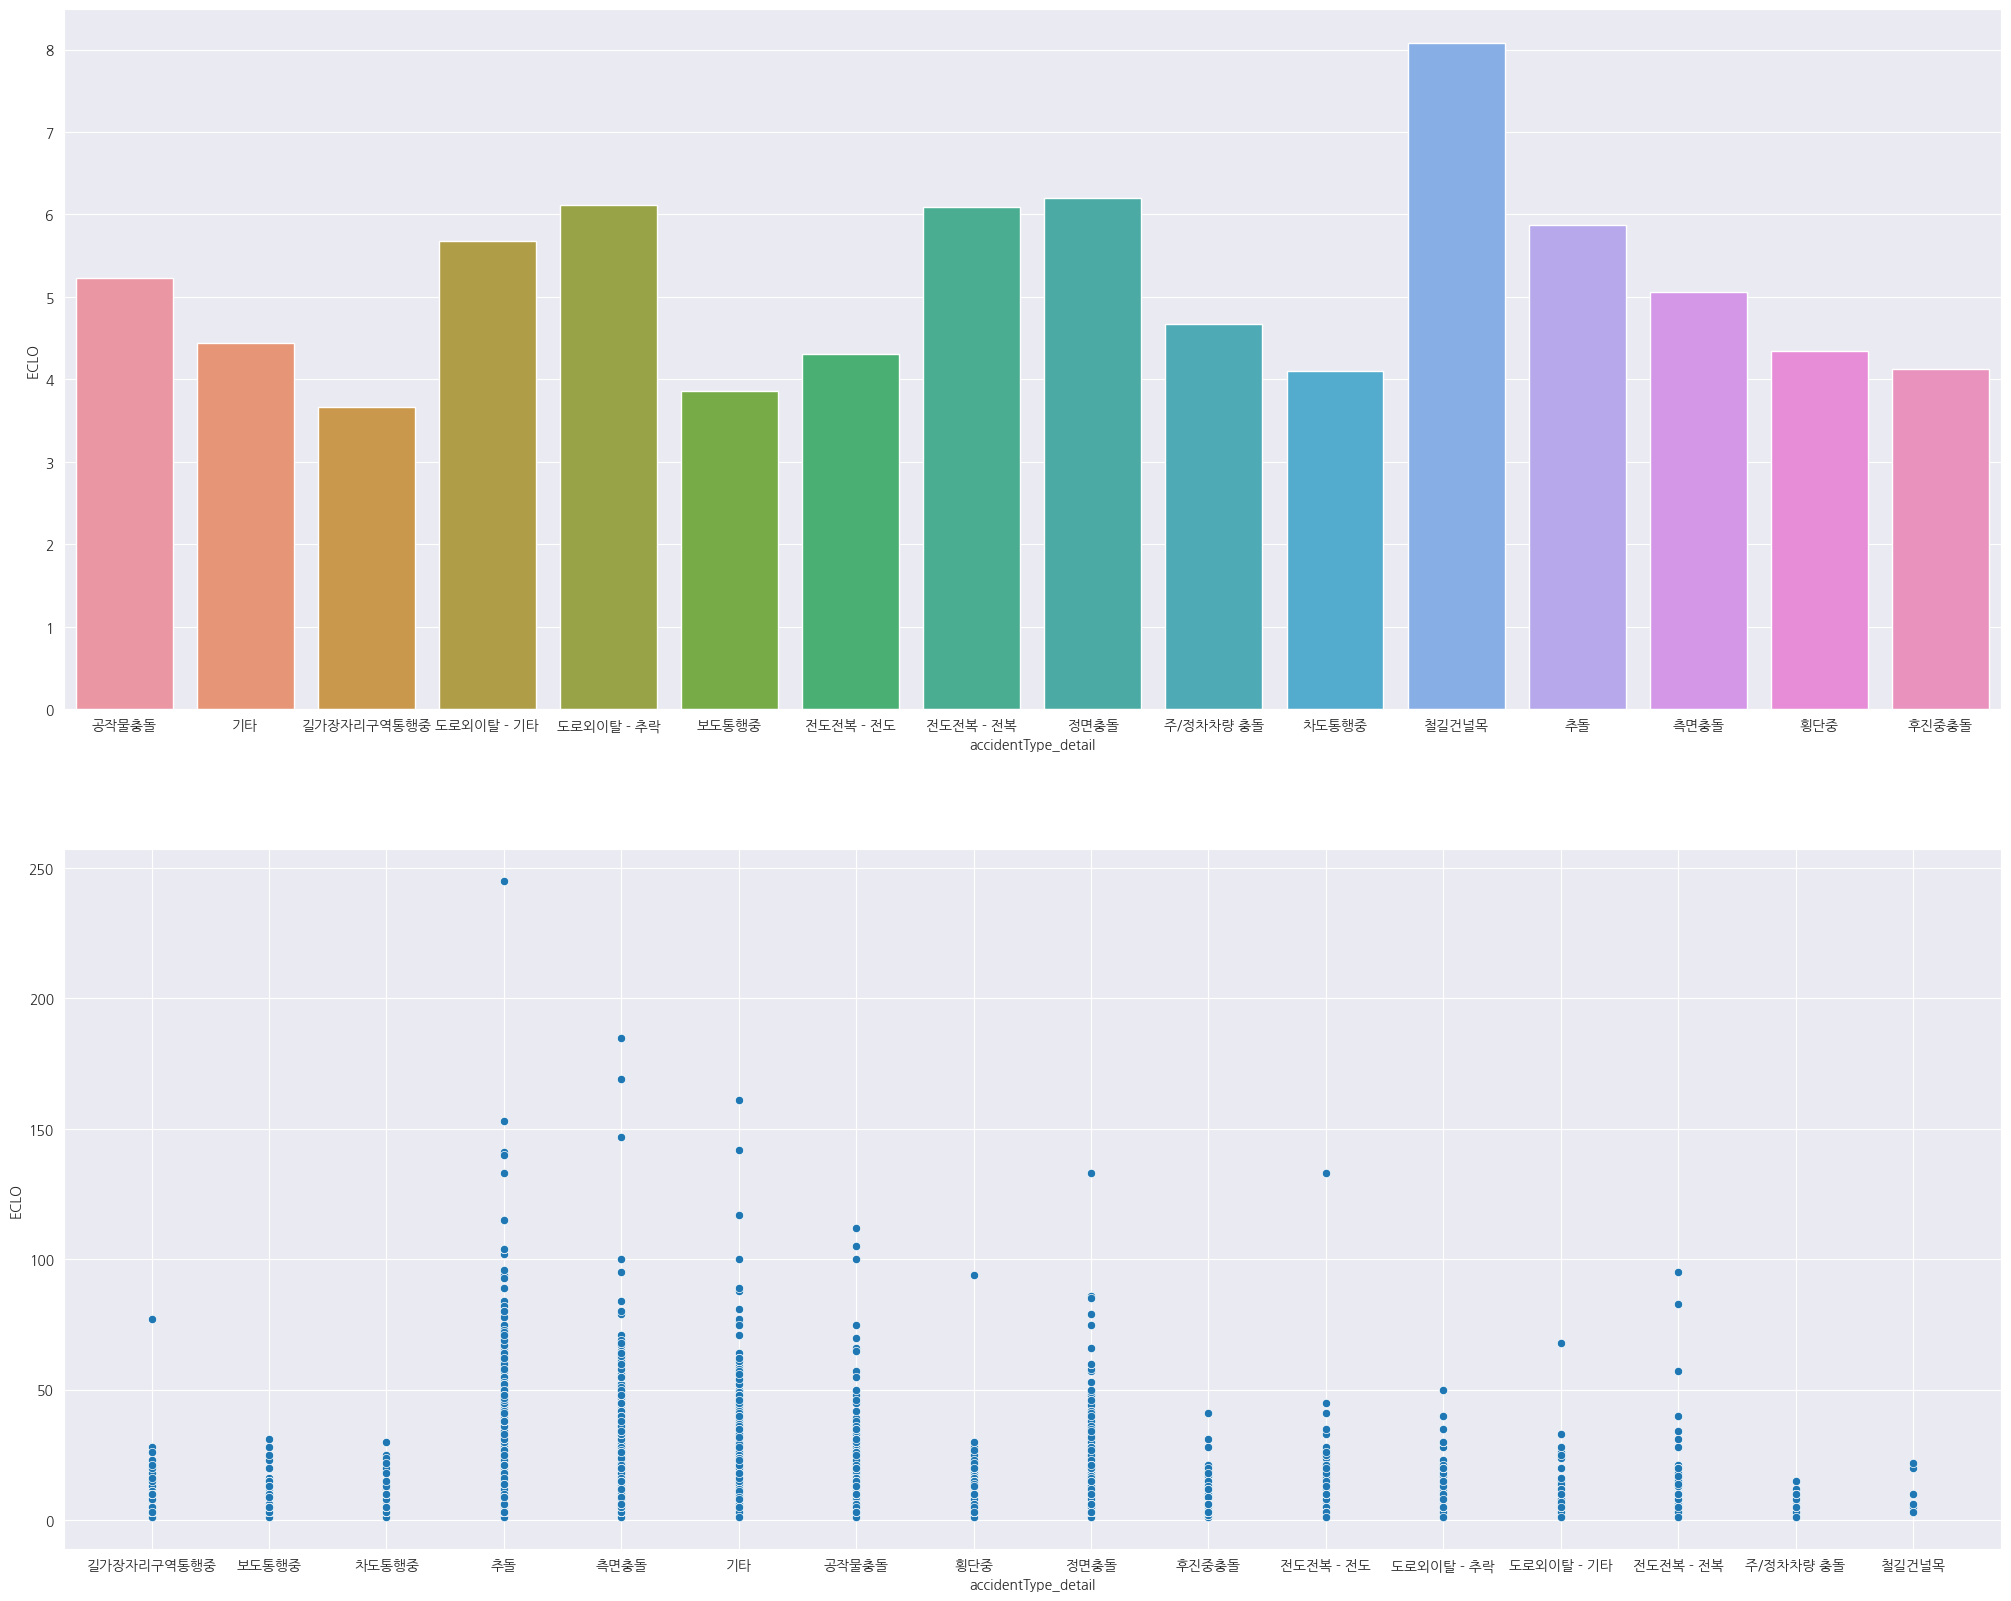

In [296]:
fig, axes = plt.subplots(2, 1, figsize=(25, 20))

avg_at = train_added.groupby('accidentType_detail')['ECLO'].mean()
sns.barplot(x=avg_at.index, y=avg_at, ax=axes[0])
sns.scatterplot(x='accidentType_detail', y='ECLO', data=train_added, ax=axes[1])

In [32]:
train.select_dtypes(np.number).columns

Index(['death', 'injuredS', 'injuredL', 'injured', 'ECLO', 'year', 'month',
       'day', 'hour'],
      dtype='object')